In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

import astropy.io.fits as pyfits

#### Δεδομένα φωτογραφίας

In [20]:
star_fits_file = "star_data.fits.gz"

star_fits_sections = pyfits.open(star_fits_file)
star_data = star_fits_sections[1].data

#### Προβολή φωτογραφίας

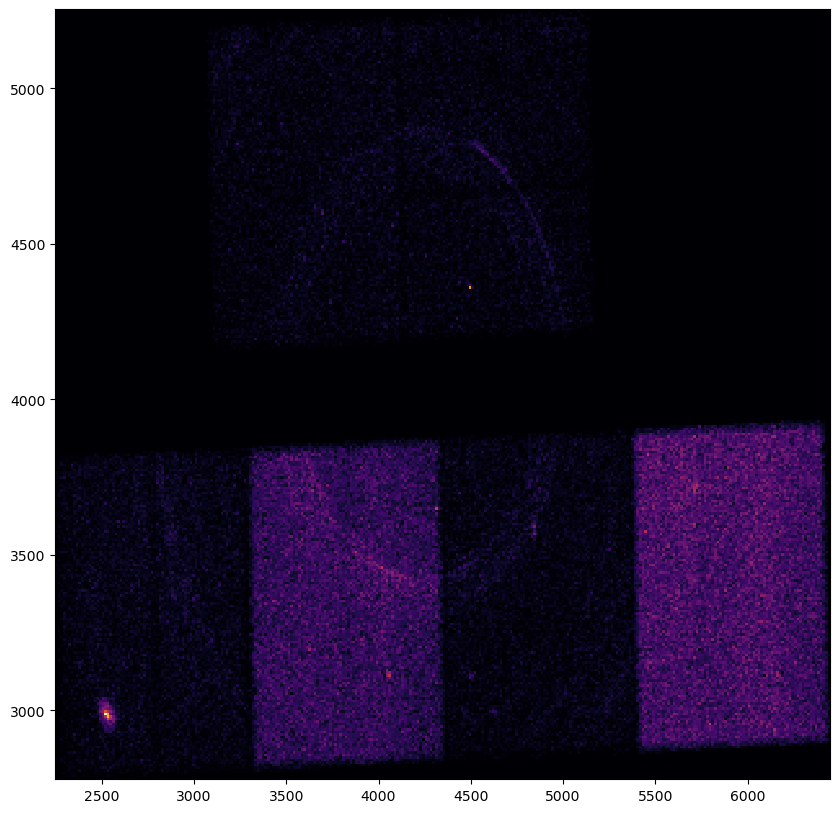

In [21]:
star_x_coords = star_data['X']
star_y_coords = star_data['Y']

plt.close('all')
plt.figure(1,figsize=(10,10))
plt.hist2d(star_x_coords, star_y_coords, bins=300, cmap='inferno')
plt.show()

#### Ορισμός γεωμετρικών στοιχείων

In [41]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

def get_distance(point1, point2):
    return np.sqrt((point1.x - point2.x)**2 + (point1.y - point2.y)**2)

zero_origin = Point(0, 0)

class Circle:
    def __init__(self, center, radius):
        self.center = center
        self.radius = radius

    def is_point_in_circle(self, point):
        return get_distance(self.center, point) - self.radius <= 0
    
    def are_points_in_circle(self, points):
        return [self.is_point_in_circle(point) for point in points]

#### Ορισμός Γεωμετρικών Χαρακτηριστικών εικόνας

In [53]:
star_center_x = 4000
star_center_y = 4250

star_origin = Point(star_center_x, star_center_y)
star_circle = Circle(star_origin, 20)

#### Έλεγχος ορθότητας επιλογής κέντρου

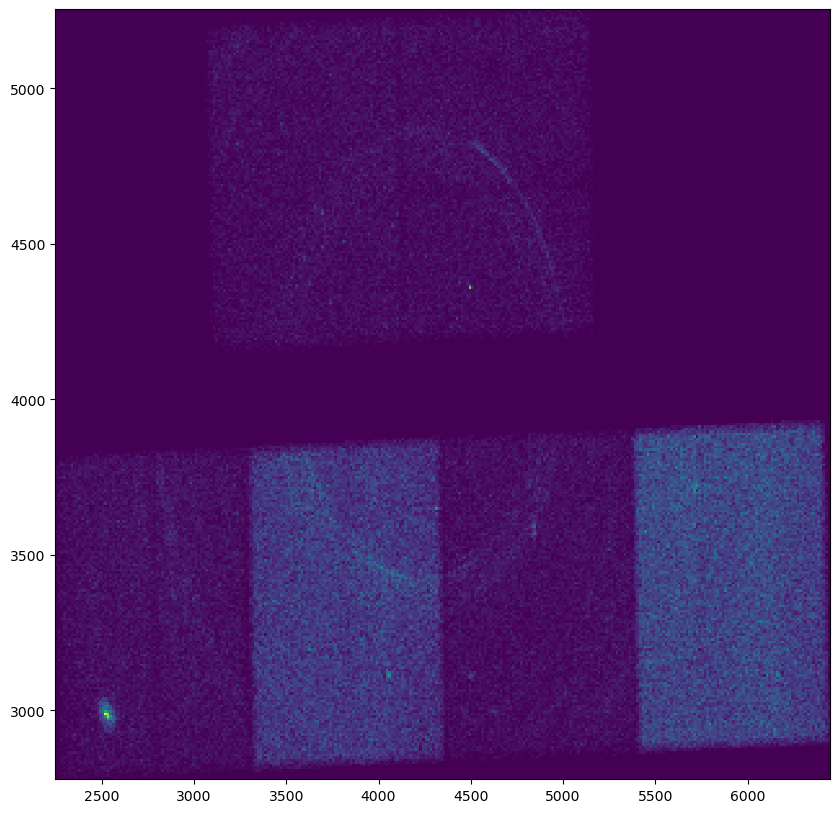

In [66]:
star_points = np.array([Point(x, y) for x, y in zip(star_x_coords, star_y_coords)])

star_origin_mask = star_circle.are_points_in_circle(star_points)

masked_star_points = star_points[star_origin_mask]
masked_star_x_coords = np.array([point.x for point in masked_star_points])
masked_star_y_coords = np.array([point.y for point in masked_star_points])

plt.close('all')
plt.figure(1,figsize=(10,10))
plt.hist2d(star_x_coords, star_y_coords, bins=300)
#plt.hist2d(masked_star_x_coords, masked_star_y_coords, bins=1000)
plt.show()